# Mesurer le risque en finance : drawdowns, VaR, ES

Ce notebook couvre : **courbe de capital**, **drawdowns**, **VaR (historique & paramétrique)**, **Expected Shortfall**, et le **backtesting de la VaR**.


> 1) Tracer la courbe de capital et les drawdowns  
> 2) Estimer la VaR historique (95 % / 99 %)  
> 3) Estimer la VaR paramétrique (gaussienne vs t-Student)  
> 4) Mesurer l’Expected Shortfall (ES / CVaR)  
> 5) Backtester la VaR  



## 0) Préparation

- Assurez-vous d'avoir `yfinance`, `pandas`, `numpy`, `scipy`, `statsmodels`, `matplotlib` installés.
- Le téléchargement des données nécessite une connexion internet côté utilisateur.


In [1]:
# !pip install yfinance statsmodels
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, t as tdist
import yfinance as yf

plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['axes.grid'] = True


## 1) Importer les données (Yahoo Finance)

Vous pouvez ajuster l'univers, les dates et l'indice de marché.  
La **courbe de capital** sera construite sur un **portefeuille équipondéré** .


In [2]:
# --- Paramètres d'import ---
UNIVERSE = ["META","AAPL","MSFT","JPM","BAC","C","XOM","CVX","JNJ","PFE","UNH"]
MARKET_TICKER = "^GSPC"       # S&P 500 (marché)
START_DATE = "2020-01-01"
END_DATE = None               # jusqu'à aujourd'hui

# --- Téléchargement ---
data = yf.download(UNIVERSE + [MARKET_TICKER],
                   start=START_DATE, end=END_DATE,
                   progress=False, auto_adjust=False)

# Extraire les prix ajustés (gère le MultiIndex de yfinance)
if isinstance(data.columns, pd.MultiIndex):
    prices = data["Adj Close"].copy()
else:
    prices = data[["Adj Close"]].copy()

prices = prices.dropna(how="all")
market_prices = prices[MARKET_TICKER].dropna()
asset_prices  = prices.drop(columns=[MARKET_TICKER], errors="ignore").dropna(how="all")

# Rendements (log)
asset_r  = np.log(asset_prices).diff().dropna(how="all")
market_r = np.log(market_prices).diff().dropna()

asset_prices.tail(), asset_r.tail()


(Ticker            AAPL        BAC           C         CVX         JNJ  \
 Date                                                                    
 2025-09-15  236.699997  50.590000   99.790001  157.309998  177.399994   
 2025-09-16  238.149994  50.660000  100.639999  159.539993  176.460007   
 2025-09-17  238.990005  51.400002  101.760002  160.089996  177.199997   
 2025-09-18  237.880005  52.130001  102.410004  158.839996  174.160004   
 2025-09-19  245.500000  52.250000  102.680000  156.210007  176.190002   
 
 Ticker             JPM        META        MSFT        PFE         UNH  \
 Date                                                                    
 2025-09-15  308.899994  764.700012  515.359985  23.969999  347.890015   
 2025-09-16  309.190002  779.000000  509.040009  23.900000  339.779999   
 2025-09-17  311.750000  775.719971  510.019989  24.049999  341.609985   
 2025-09-18  313.230011  780.250000  508.450012  24.150000  334.820007   
 2025-09-19  314.779999  778.380005 

## 2) Courbe de capital & drawdowns

- **Equity curve** (portefeuille équipondéré par défaut).  
- **Drawdown** = baisse relative par rapport au plus-haut historique.  
- **Maximum drawdown** et **Time Under Water** (durée sous l’eau).

In [3]:
# Portefeuille équipondéré (modifiable)
weights = np.repeat(1/asset_prices.shape[1], asset_prices.shape[1])
port_r = (asset_r @ weights).dropna()
equity = (1 + port_r).cumprod()

# Drawdowns
hwm = equity.cummax()
drawdown = equity / hwm - 1.0

# Time Under Water (en jours)
tuw = (drawdown < 0).astype(int)
tuw_durations = []
count = 0
for v in tuw.values:
    if v == 1:
        count += 1
    else:
        if count > 0:
            tuw_durations.append(count)
        count = 0
if count > 0:
    tuw_durations.append(count)

max_dd = drawdown.min()
max_tuw = max(tuw_durations) if tuw_durations else 0

print(f"Maximum drawdown : {max_dd:.2%}")
print(f"Time Under Water (max) : {max_tuw} jours")

Maximum drawdown : -42.23%
Time Under Water (max) : 512 jours


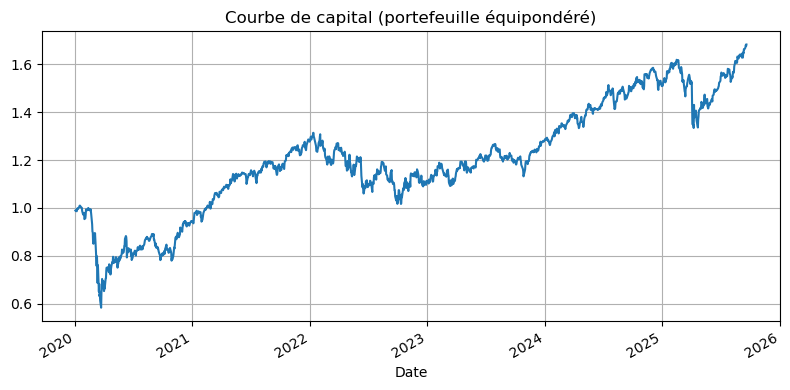

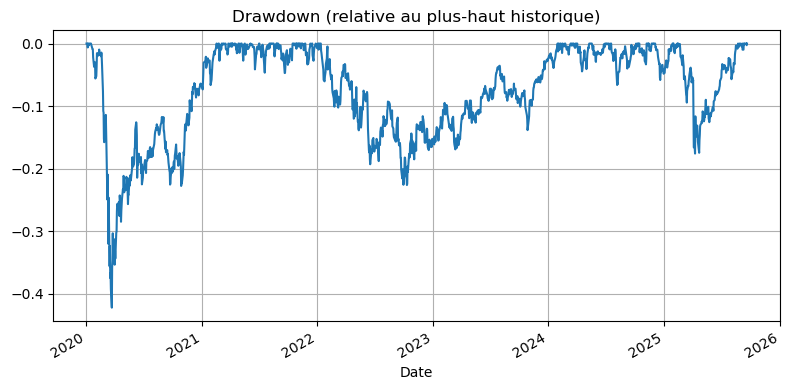

In [4]:
# Plot 1 : Equity curve
plt.figure()
equity.plot()
plt.title("Courbe de capital (portefeuille équipondéré)")
plt.tight_layout()
plt.show()

# Plot 2 : Drawdown
plt.figure()
drawdown.plot()
plt.title("Drawdown (relative au plus-haut historique)")
plt.tight_layout()
plt.show()

## 3) VaR historique (95 % / 99 %)

VaR historique par **quantile empirique** sur une **fenêtre glissante** (one-day-ahead).  
Interprétation : « **perte non dépassée** avec probabilité **α** » (ici 95 % / 99 %).

In [5]:
# Paramètres
window = 252  # ~1 an boursier
conf_levels = [0.95, 0.99]
tail = [1 - c for c in conf_levels]

# VaR historique (positive = perte)
var_hist = {}
for c in conf_levels:
    q = 1 - c  # ex: 0.05 pour 95%
    # quantile des rendements (fenêtre t-1), forecast pour t
    v = -port_r.rolling(window).quantile(q).shift(1)
    var_hist[c] = v

var_hist_df = pd.DataFrame(var_hist).rename(columns={0.95: "VaR_H_95", 0.99: "VaR_H_99"})
var_hist_df.tail()


,VaR_H_95,VaR_H_99
Date,,
2025-09-15,0.014211,0.03002
2025-09-16,0.014211,0.03002
2025-09-17,0.014211,0.03002
2025-09-18,0.014211,0.03002
2025-09-19,0.014211,0.03002


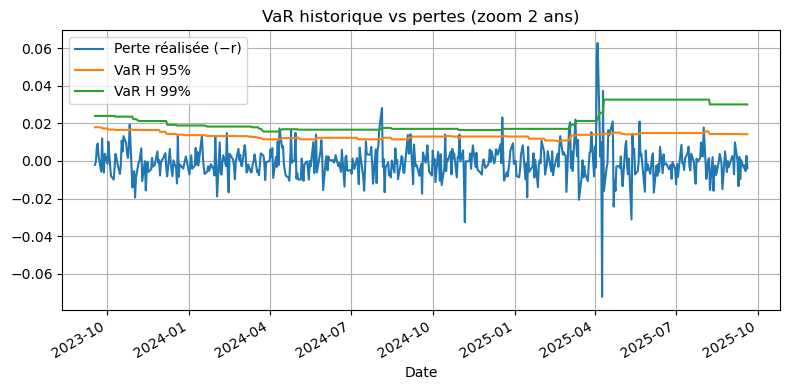

In [6]:
# Plot : VaR historique vs pertes réalisées (zoom dernières 2 années)
last_n = 2 * 252
loss = (-port_r).iloc[-last_n:]  # pertes positives
plt.figure()
loss.plot(label="Perte réalisée (−r)")
var_hist_df.iloc[-last_n:, 0].plot(label="VaR H 95%")
var_hist_df.iloc[-last_n:, 1].plot(label="VaR H 99%")
plt.legend()
plt.title("VaR historique vs pertes (zoom 2 ans)")
plt.tight_layout()
plt.show()

## 4) VaR paramétrique (gaussienne vs t-Student)

- **Normale** : VaR = −(μ + z·σ), avec *z* le quantile de la loi normale standard au niveau de la **queue** (1−α).  
- **Student-t** : VaR = −(loc + scale · t.ppf(1−α, df)), paramètres estimés sur fenêtre glissante.

> Remarque : estimation *t* par `scipy.stats.t.fit` (peut être lente sur de très grandes séries).

In [7]:
from math import sqrt

# VaR paramétrique Normale (rolling)
mu = port_r.rolling(window).mean().shift(1)
sigma = port_r.rolling(window).std(ddof=1).shift(1)

var_norm = {}
for c in conf_levels:
    a = 1 - c  # queue
    z = norm.ppf(a)   # quantile de gauche (ex: 5% → z négatif)
    v = -(mu + z * sigma)
    var_norm[c] = v

var_norm_df = pd.DataFrame(var_norm).rename(columns={0.95: "VaR_N_95", 0.99: "VaR_N_99"})
var_norm_df.tail()

,VaR_N_95,VaR_N_99
Date,,
2025-09-15,0.017576,0.025098
2025-09-16,0.017560,0.025083
2025-09-17,0.017561,0.025084
2025-09-18,0.017555,0.025080
2025-09-19,0.017584,0.025104


In [8]:
# VaR paramétrique Student-t (rolling fit)

ret = port_r.copy()
idx = ret.index
var_t = {0.95: pd.Series(index=idx, dtype=float),
         0.99: pd.Series(index=idx, dtype=float)}

for i in range(window, len(ret)):
    w = ret.iloc[i-window:i].dropna().values
    if len(w) < window:
        continue
    # Fit t: retourne (df, loc, scale)
    df_t, loc_t, scale_t = tdist.fit(w)
    for c in conf_levels:
        a = 1 - c
        q = tdist.ppf(a, df_t)  # quantile de gauche (négatif)
        v = -(loc_t + scale_t * q)
        var_t[c].iloc[i] = v

var_t_df = pd.concat([var_t[0.95].rename("VaR_T_95"),
                      var_t[0.99].rename("VaR_T_99")], axis=1)
var_t_df.tail()

,VaR_T_95,VaR_T_99
Date,,
2025-09-15,0.013839,0.029197
2025-09-16,0.013805,0.029132
2025-09-17,0.013808,0.029146
2025-09-18,0.013801,0.029050
2025-09-19,0.013841,0.029180


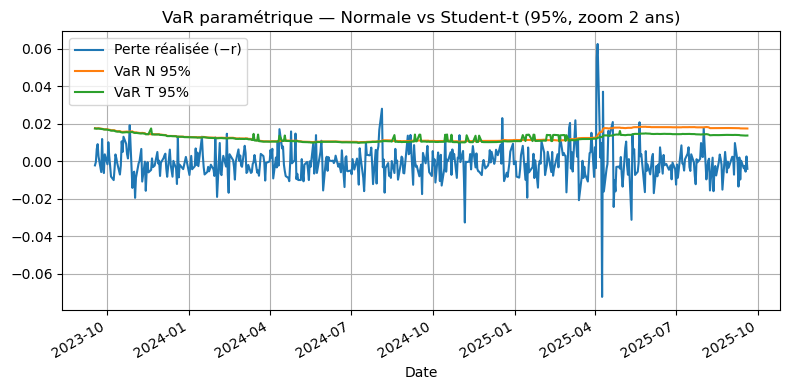

In [9]:
# Plot : comparaison des VaR (zoom 2 ans)
last_n = 2 * 252
plt.figure()
(-port_r).iloc[-last_n:].plot(label="Perte réalisée (−r)")
var_norm_df["VaR_N_95"].iloc[-last_n:].plot(label="VaR N 95%")
var_t_df["VaR_T_95"].iloc[-last_n:].plot(label="VaR T 95%")
plt.legend()
plt.title("VaR paramétrique — Normale vs Student-t (95%, zoom 2 ans)")
plt.tight_layout()
plt.show()

## 5) Expected Shortfall (ES / CVaR)

- **Historique** : moyenne des pertes au-delà de la VaR historique (même fenêtre).  
- **Paramétrique Normal** : ES = −( μ − σ · φ(z)/α_tail ), où z = Φ⁻¹(α_tail) (gauche).  
- **Paramétrique Student-t** : ES = −( loc + scale · ((ν + q²)/(ν − 1)) · f(q)/α_tail ), q = t.ppf(α_tail), f = pdf t.

> Convention : ES rendu en **perte positive**.


In [10]:
# ES historique (rolling, one-day-ahead)
def es_historical(r, window, conf=0.95):
    a = 1 - conf
    out = pd.Series(index=r.index, dtype=float)
    for i in range(window, len(r)):
        w = r.iloc[i-window:i].dropna()
        if len(w) < 1:
            continue
        q = w.quantile(a)
        tail_losses = w[w <= q]
        out.iloc[i] = -tail_losses.mean()  # perte positive
    return out

es_hist_95 = es_historical(port_r, window, 0.95)
es_hist_99 = es_historical(port_r, window, 0.99)

# ES Normal (rolling)
def es_normal(mu, sigma, conf=0.95):
    a = 1 - conf
    z = norm.ppf(a)
    phi = norm.pdf(z)
    es = -(mu - sigma * (phi / a))
    return es

es_norm_95 = es_normal(mu, sigma, 0.95)
es_norm_99 = es_normal(mu, sigma, 0.99)

# ES Student-t (rolling, utilise var_t params indirectement via re-fit)
def es_student_series(r, window, conf=0.95):
    a = 1 - conf
    out = pd.Series(index=r.index, dtype=float)
    for i in range(window, len(r)):
        w = r.iloc[i-window:i].dropna().values
        if len(w) < window:
            continue
        df_t, loc_t, scale_t = tdist.fit(w)
        q = tdist.ppf(a, df_t)
        pdf_q = tdist.pdf(q, df_t)
        es = -(loc_t + scale_t * ((df_t + q**2) / (df_t - 1)) * (pdf_q / a))
        out.iloc[i] = es
    return out

es_t_95 = es_student_series(port_r, window, 0.95)
es_t_99 = es_student_series(port_r, window, 0.99)

pd.DataFrame({
    "ES_H_95": es_hist_95,
    "ES_N_95": es_norm_95,
    "ES_T_95": es_t_95
}).tail()

,ES_H_95,ES_N_95,ES_T_95
Date,,,
2025-09-15,0.026502,0.022188,-0.026515
2025-09-16,0.026502,0.022173,-0.026525
2025-09-17,0.026502,0.022174,-0.026531
2025-09-18,0.026502,0.022169,-0.026476
2025-09-19,0.026502,0.022195,-0.026477


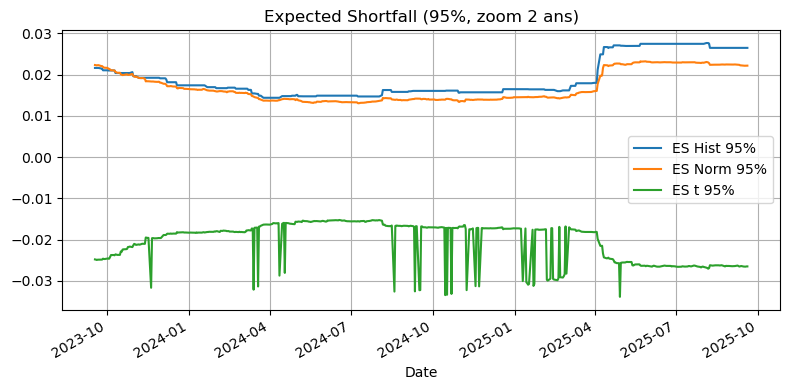

In [11]:
# Plot ES (95%, zoom 2 ans)
last_n = 2 * 252
plt.figure()
es_hist_95.iloc[-last_n:].plot(label="ES Hist 95%")
es_norm_95.iloc[-last_n:].plot(label="ES Norm 95%")
es_t_95.iloc[-last_n:].plot(label="ES t 95%")
plt.legend()
plt.title("Expected Shortfall (95%, zoom 2 ans)")
plt.tight_layout()
plt.show()

## 6) Backtester la VaR 

On compare le **taux d'exceptions** observé à la **probabilité attendue** *(1−α)*.  
On calcule aussi le **test de Kupiec (POF)** pour la **couverture inconditionnelle**.

In [12]:
from scipy.stats import chi2

def kupiec_pof_test(loss, var_series, conf=0.95):
    # loss : pertes positives = -r
    # var_series : VaR en perte positive (alignée)
    tail = 1 - conf
    valid = loss.notna() & var_series.notna()
    L = loss[valid]
    V = var_series[valid]
    x = (L > V).sum()   # exceptions
    N = valid.sum()
    pi_hat = x / N if N > 0 else np.nan
    # log-vraisemblances
    from math import log
    ll_null = (N - x) * log(1 - tail) + x * log(tail) if N > 0 else np.nan
    ll_hat  = (N - x) * log(1 - pi_hat) + x * log(pi_hat) if (N > 0 and 0 < pi_hat < 1) else np.nan
    LR_uc = -2 * (ll_null - ll_hat) if (ll_null is not np.nan and ll_hat is not np.nan) else np.nan
    pval = 1 - chi2.cdf(LR_uc, df=1) if LR_uc is not np.nan else np.nan
    return {"N": int(N), "x": int(x), "rate_obs": pi_hat, "rate_exp": tail, "LR_uc": LR_uc, "pval": pval}

loss = -port_r

bt_hist_95 = kupiec_pof_test(loss, var_hist_df["VaR_H_95"], 0.95)
bt_hist_99 = kupiec_pof_test(loss, var_hist_df["VaR_H_99"], 0.99)
bt_norm_95 = kupiec_pof_test(loss, var_norm_df["VaR_N_95"], 0.95)
bt_t_95    = kupiec_pof_test(loss, var_t_df["VaR_T_95"], 0.95)

pd.DataFrame([bt_hist_95, bt_hist_99, bt_norm_95, bt_t_95],
             index=["Hist 95", "Hist 99", "Normal 95", "t 95"])


,N,x,rate_obs,rate_exp,LR_uc,pval
Hist 95,1184,56,0.047297,0.05,0.185272,0.666881
Hist 99,1184,20,0.016892,0.01,4.706884,0.030042
Normal 95,1184,59,0.049831,0.05,0.000712,0.978712
t 95,1184,60,0.050676,0.05,0.011332,0.915225


## 7) Défi — VaR historique 99 % (portefeuille simple, 4 titres)

**Portefeuille (équipondéré)**
- AAPL (25 %)
- MSFT (25 %)
- JPM  (25 %)
- XOM  (25 %)

**Objectif**
Calculez la **Value at Risk (VaR) historique à 99 %** sur **1 jour** pour ce portefeuille, en utilisant une **fenêtre glissante de 252 jours**.

**Consignes**
1. Construire les **rendements du portefeuille** à partir des quatre titres (pondération égale).
2. Pour chaque date *t*, estimer le **quantile empirique 1 %** des rendements des **252 jours précédents** *(t−1 … t−252)*.
3. **Décaler d’un jour** (prévision pour *t*) et exprimer la VaR en **perte positive**.


## 8) Solution 

Ci-dessous, une trame **réutilisable** : ajustez `UNIVERSE`, les **poids**, la **fenêtre**, et les **niveaux de confiance** selon votre cas.  
Relisez les **hypothèses** (stationnarité, distributions, indépendance) et testez la **stabilité par sous-périodes**.


# Solution

In [13]:
# ============================================================
# VaR historique 99% (1-day-ahead) — portefeuille simple (4 titres)
# Tickers demandés : AAPL, MSFT, JPM, XOM (poids égaux)
# Prérequis (une fois) : pip install yfinance
# ============================================================

import pandas as pd
import numpy as np
import yfinance as yf
# import matplotlib.pyplot as plt  # (optionnel pour tracer)

# --- Paramètres ---
tickers = ["AAPL","MSFT","JPM","XOM"]
START_DATE = "2020-01-01"
END_DATE = None  # jusqu'à aujourd'hui
alpha_tail = 0.01   # 1% → VaR 99%
window = 252        # ~1 an boursier

# --- Téléchargement des prix ajustés ---
data = yf.download(
    tickers,
    start=START_DATE, end=END_DATE,
    interval="1d", progress=False, auto_adjust=False
)

# Extraire 'Adj Close' (gère le MultiIndex)
if isinstance(data.columns, pd.MultiIndex):
    prices = data["Adj Close"].copy()
else:
    prices = data[["Adj Close"]].copy()

prices = prices.dropna(how="all")
prices = prices[tickers].dropna(how="all")  # ne garder que les 4 tickers

# --- Rendements (log) ---
ret = np.log(prices).diff().dropna()

# --- Portefeuille équipondéré (poids égaux) ---
w = np.repeat(1/len(tickers), len(tickers))
port_r = ret.dot(w)

# --- VaR historique 99% (fenêtre glissante, prévision t+1) ---
var_99 = -port_r.rolling(window).quantile(alpha_tail).shift(1).dropna()  # perte positive (≥ 0)

# --- Sortie principale ---
print("Dernière date VaR_99% :", var_99.index[-1].date())
print("VaR_99% (historique, 1j) :", f"{100*var_99.iloc[-1]:.2f}%")

# (Option) Visualisation sur ~2 ans :
# loss = (-port_r).loc[var_99.index]  # pertes positives
# last_n = 2*252
# plt.figure(figsize=(8,3.5))
# loss.iloc[-last_n:].plot(label="Perte réalisée (−r)")
# var_99.iloc[-last_n:].plot(label="VaR 99% (historique)")
# plt.legend(); plt.title("VaR historique 99% (fenêtre 252, one-day-ahead)")
# plt.tight_layout(); plt.show()


Dernière date VaR_99% : 2025-09-19
VaR_99% (historique, 1j) : 3.29%
